## FLOWER RECOGNITION KAGGLE USING TRANSFER LEARNING (VGG 16).¶

## Please upvote / star if you like it.

#### Note::->
This notebook was run on Google Colab and some part of this thus contains code specific to the authorisation, other functionalities on the Google colab.

Thus you may skip that part while reading the notebook and may focus onto the modelling specific part.

## CONTENTS ::¶

#### 1 ) Importing Various Modules.

#### 2 ) Preparing the Data

#### 3 ) Modelling

#### 4 ) Visualizing Predictons on the Validation Set

## 1 ) Importing Various Modules.

In [0]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
% matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!apt-get install -f
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Redirecting output to ‘wget-log.4’.
(Reading database ... 19845 files and directories currently installed.)
Preparing to unpack google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1) over (0.7.0-0ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
··········


In [3]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


## 2 ) Preparing the Data

## 2.1) Making the functions to get the training and validation set from the Images

In [0]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='drive/Colab Notebooks/flower recog/flowers/daisy'
FLOWER_SUNFLOWER_DIR='drive/Colab Notebooks/flower recog/flowers/sunflower'
FLOWER_TULIP_DIR='drive/Colab Notebooks/flower recog/flowers/tulip'
FLOWER_DANDI_DIR='drive/Colab Notebooks/flower recog/flowers/dandelion'
FLOWER_ROSE_DIR='drive/Colab Notebooks/flower recog/flowers/rose'


In [0]:
def assign_label(img,flower_type):
    return flower_type
    

In [0]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
        
        
        

In [7]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 769/769 [00:06<00:00, 112.04it/s]

769


In [8]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 766/766 [00:07<00:00, 108.79it/s]

1535


In [9]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 991/991 [00:09<00:00, 106.71it/s]

2526


In [10]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:09<00:00, 116.09it/s]

3578


In [11]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:06<00:00, 117.50it/s]

4362


## 2.2 ) Visualizing some Random Images

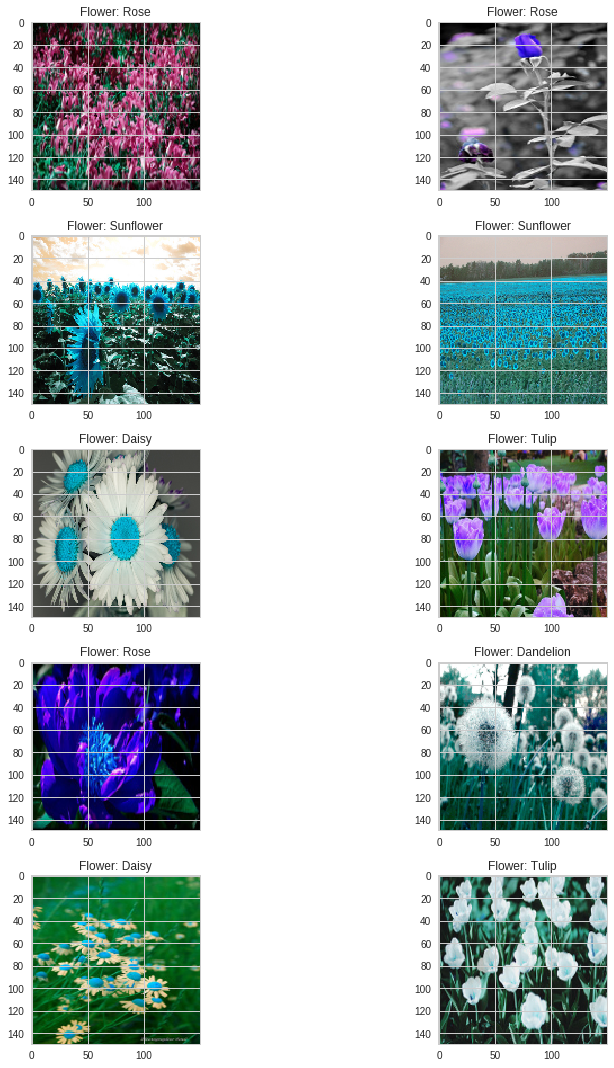

In [12]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding 

In [0]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [0]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


## 2.5 ) Setting the Random Seeds

In [0]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

## 3 ) Modelling

## 3.1 ) Specifying the Base Model

Transfer learning refers to using a pretrained model on some other task for your own task. Hence we need to specify the particular model which we are deploying in our task and thus needs to specify the base model.

In our case we are using the VGG16 model from the Keras.Applications library as the base model.

In [0]:
base_model=VGG16(include_top=False, weights='imagenet',input_shape=(150,150,3), pooling='avg')
 

#### BREAKING IT DOWN--

1) Firstly we import the VGG16 module from the Keras library.

2) Next we need to specify if we want  to use the fully connected layers of the VGG16 module or own layers. Since our task is different and we have only 5 target classes we need to have our own layers and I have specified the 'include_top' arguement as 'False'.

3) Next we need to specify the weights to be used by the model. Since I want it to use the weights it was trained on in ImageNet competition, I have specified the corressponding arguement.

4) Lastly we just need to specify the shape of the imput that our model need to expect and also specify the 'pooling' type.

In [54]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Note that this is NOT the summary of our model and this is the summary or the ARCHITECTURE of the VGG16 model that we are deploying as the base model.

## 3.2 ) Adding our Own Fully Connected Layers

Now we need to add at the top of the base model some fully connected layers. Alsowe can use the BatchNormalization and the Dropout layers as usual in case we want to.

For this I have used a Keras sequential model and build our entire model on top of it; comprising of the VGG model as the base model + our own fully connected layers.

In [0]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))




## 3.3 ) Data Augmentation to prevent Overfitting

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 3.4 ) Using a Learning Rate Annealer & the Summary

In [0]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 14,847,301
Non-trainable params: 0
_________________________________________________________________


This is now the complete summary of our model that we shall use to classify the images.

## 3.5 ) Compiling & Training the Model

#### 3.5.1 ) USING BASE MODEL AS A FEATURE EXTRACTOR.

While using transfer learning in ConvNet; we have basically have 3 main approaches-->

1) To use the pretrained model as a feature extractor and just train your classifier on top of it. In this method we do not tune any weights of the model.

2) Fine Tuning- In this approach we tune the weights of the pretrained model. This can be done by unfreezing the layers that we want to train.In that case these layers will be initialised with their trained weights on imagenet.

3) Lasty we can use a pretrained model.

Note that in this section I have used the first approach ie I have just use the conv layers and added my own fully connected layers on top of VGG model. Thus I have trained a classifier on top of the CNN codes.

In [0]:
base_model.trainable=False # setting the VGG model to be untrainable.

In [0]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])



In [61]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
25/25 [==============================] - 27s 1s/step - loss: 1.5938 - acc: 0.3061 - val_loss: 1.5392 - val_acc: 0.3520
Epoch 2/50
25/25 [==============================] - 26s 1s/step - loss: 1.4755 - acc: 0.4129 - val_loss: 1.4332 - val_acc: 0.4345
Epoch 3/50
25/25 [==============================] - 26s 1s/step - loss: 1.3768 - acc: 0.5020 - val_loss: 1.3354 - val_acc: 0.5197
Epoch 4/50
25/25 [==============================] - 27s 1s/step - loss: 1.2828 - acc: 0.5806 - val_loss: 1.2469 - val_acc: 0.5775
Epoch 5/50
25/25 [==============================] - 25s 1s/step - loss: 1.1960 - acc: 0.6151 - val_loss: 1.1708 - val_acc: 0.6068
Epoch 6/50
25/25 [==============================] - 24s 973ms/step - loss: 1.1321 - acc: 0.6383 - val_loss: 1.1049 - val_acc: 0.6334
Epoch 7/50
25/25 [==============================] - 24s 964ms/step - loss: 1.0660 - acc: 0.6590 - val_loss: 1.0522 - val_acc: 0.6471
Epoch 8/50
25/25 [==============================] - 24s 956ms/step - loss: 1.0191 - 

#### 3.5.2 ) FINE TUNING BY UNFREEZING THE LAST BLOCK OF VGG16

In this section I have done fine tuning. To see the effect of the fine tuning I have first unfreezed the last block of the VGG16 model and have set it to trainable.

In [62]:
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i])
  
 for layer in base_model.layers[15:]:
    layer.trainable=True
for layer in base_model.layers[0:15]:
    layer.trainable=False
  

0 <keras.engine.topology.InputLayer object at 0x7f3e22af25f8>
1 <keras.layers.convolutional.Conv2D object at 0x7f3e22af2a20>
2 <keras.layers.convolutional.Conv2D object at 0x7f3e22af29b0>
3 <keras.layers.pooling.MaxPooling2D object at 0x7f3e22af2710>
4 <keras.layers.convolutional.Conv2D object at 0x7f3e22eed278>
5 <keras.layers.convolutional.Conv2D object at 0x7f3e22e23470>
6 <keras.layers.pooling.MaxPooling2D object at 0x7f3e22e14cc0>
7 <keras.layers.convolutional.Conv2D object at 0x7f3db4950c18>
8 <keras.layers.convolutional.Conv2D object at 0x7f3db494fc18>
9 <keras.layers.convolutional.Conv2D object at 0x7f3db8984358>
10 <keras.layers.pooling.MaxPooling2D object at 0x7f3db895d6d8>
11 <keras.layers.convolutional.Conv2D object at 0x7f3db89740f0>
12 <keras.layers.convolutional.Conv2D object at 0x7f3db8907550>
13 <keras.layers.convolutional.Conv2D object at 0x7f3db89074e0>
14 <keras.layers.pooling.MaxPooling2D object at 0x7f3db892b6d8>
15 <keras.layers.convolutional.Conv2D object at 0x7

In [0]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])



In [64]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
25/25 [==============================] - 28s 1s/step - loss: 0.5600 - acc: 0.7997 - val_loss: 0.6063 - val_acc: 0.7864
Epoch 2/50
25/25 [==============================] - 26s 1s/step - loss: 0.5469 - acc: 0.8048 - val_loss: 0.6032 - val_acc: 0.7773
Epoch 3/50
25/25 [==============================] - 26s 1s/step - loss: 0.5562 - acc: 0.7934 - val_loss: 0.5977 - val_acc: 0.7901
Epoch 4/50
25/25 [==============================] - 26s 1s/step - loss: 0.5375 - acc: 0.8163 - val_loss: 0.5941 - val_acc: 0.7892
Epoch 5/50
25/25 [==============================] - 26s 1s/step - loss: 0.5449 - acc: 0.8094 - val_loss: 0.5945 - val_acc: 0.7819
Epoch 6/50
25/25 [==============================] - 25s 1000ms/step - loss: 0.5501 - acc: 0.8031 - val_loss: 0.5916 - val_acc: 0.7855
Epoch 7/50
25/25 [==============================] - 25s 990ms/step - loss: 0.5391 - acc: 0.8068 - val_loss: 0.5895 - val_acc: 0.7864
Epoch 8/50
25/25 [==============================] - 24s 975ms/step - loss: 0.5226 -

#### Note that the validation accuracy on fine tuning by unfreezing the last block of the VGG16 model has increased to about 81% ; almost by 3% as compared to the case when we run a classifier on the top of the CNN codes in previous section.

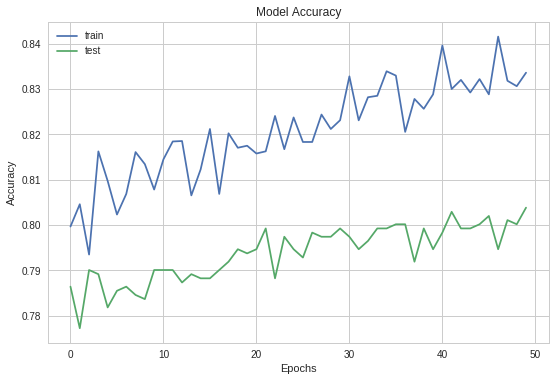

In [65]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

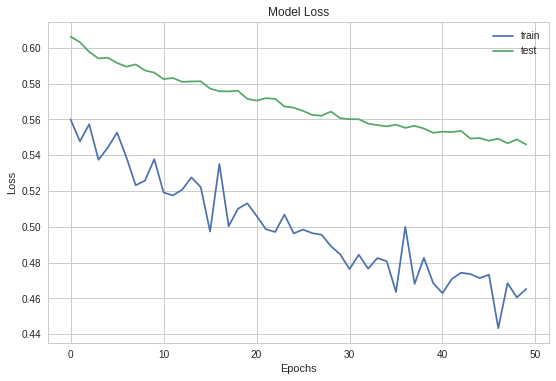

In [66]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### 3.5.3) UNFREEZING THE LAST 2 BLOCKS

Similarly unffreezing the last 2 blocks of the VGG16model.

In [67]:
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i])
  
  for layer in base_model.layers[11:]:
    layer.trainable=True
for layer in base_model.layers[0:11]:
    layer.trainable=False
  

0 <keras.engine.topology.InputLayer object at 0x7f3e22af25f8>
1 <keras.layers.convolutional.Conv2D object at 0x7f3e22af2a20>
2 <keras.layers.convolutional.Conv2D object at 0x7f3e22af29b0>
3 <keras.layers.pooling.MaxPooling2D object at 0x7f3e22af2710>
4 <keras.layers.convolutional.Conv2D object at 0x7f3e22eed278>
5 <keras.layers.convolutional.Conv2D object at 0x7f3e22e23470>
6 <keras.layers.pooling.MaxPooling2D object at 0x7f3e22e14cc0>
7 <keras.layers.convolutional.Conv2D object at 0x7f3db4950c18>
8 <keras.layers.convolutional.Conv2D object at 0x7f3db494fc18>
9 <keras.layers.convolutional.Conv2D object at 0x7f3db8984358>
10 <keras.layers.pooling.MaxPooling2D object at 0x7f3db895d6d8>
11 <keras.layers.convolutional.Conv2D object at 0x7f3db89740f0>
12 <keras.layers.convolutional.Conv2D object at 0x7f3db8907550>
13 <keras.layers.convolutional.Conv2D object at 0x7f3db89074e0>
14 <keras.layers.pooling.MaxPooling2D object at 0x7f3db892b6d8>
15 <keras.layers.convolutional.Conv2D object at 0x7

In [0]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])



In [69]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
25/25 [==============================] - 28s 1s/step - loss: 0.4664 - acc: 0.8331 - val_loss: 0.5487 - val_acc: 0.8029
Epoch 2/50
25/25 [==============================] - 27s 1s/step - loss: 0.4569 - acc: 0.8357 - val_loss: 0.5455 - val_acc: 0.8029
Epoch 3/50
25/25 [==============================] - 26s 1s/step - loss: 0.4637 - acc: 0.8365 - val_loss: 0.5427 - val_acc: 0.8103
Epoch 4/50
25/25 [==============================] - 25s 1s/step - loss: 0.4548 - acc: 0.8333 - val_loss: 0.5448 - val_acc: 0.8057
Epoch 5/50
25/25 [==============================] - 25s 1s/step - loss: 0.4684 - acc: 0.8297 - val_loss: 0.5433 - val_acc: 0.8020
Epoch 6/50
25/25 [==============================] - 25s 995ms/step - loss: 0.4327 - acc: 0.8510 - val_loss: 0.5414 - val_acc: 0.8048
Epoch 7/50
25/25 [==============================] - 24s 967ms/step - loss: 0.4568 - acc: 0.8432 - val_loss: 0.5419 - val_acc: 0.8020
Epoch 8/50
25/25 [==============================] - 24s 969ms/step - loss: 0.4587 - 

#### Note that there is still an increse in validation accuracy of about 1.5% and the same has now reached to about 81.5%.

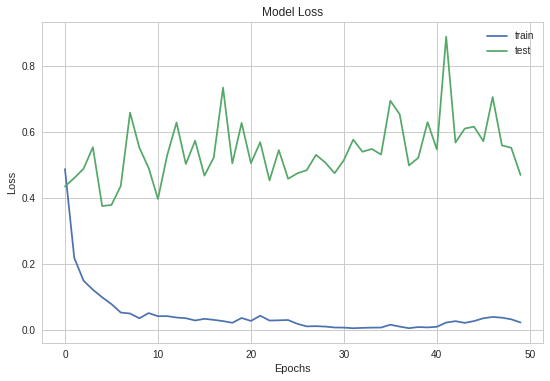

In [77]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

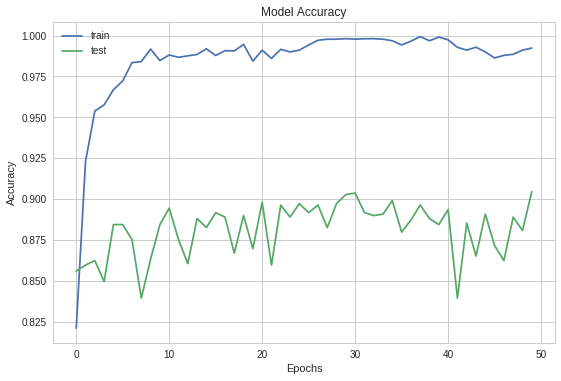

In [78]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### 3.5.4 ) TRAINING THE ENTIRE MODEL FROM SCRATCH

Finally I have tried to train the model from scratch. Note this is not reasonable though as our data is also not much similar with the imagenet data plus we are quite short of data as we only have around 4200 images.

Hence this model is quite prone to overfitting and I have done this just to check that the results validate with the though-process.

In [0]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5,activation='softmax'))


for layer in base_model.layers:
    layer.trainable=True

model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])



In [97]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
25/25 [==============================] - 51s 2s/step - loss: 0.1292 - acc: 0.9633 - val_loss: 0.4174 - val_acc: 0.8937
Epoch 2/50
25/25 [==============================] - 46s 2s/step - loss: 0.0432 - acc: 0.9860 - val_loss: 0.5218 - val_acc: 0.8808
Epoch 3/50
25/25 [==============================] - 46s 2s/step - loss: 0.0407 - acc: 0.9870 - val_loss: 0.5067 - val_acc: 0.8808
Epoch 4/50
25/25 [==============================] - 46s 2s/step - loss: 0.0237 - acc: 0.9937 - val_loss: 0.6622 - val_acc: 0.8561
Epoch 5/50
25/25 [==============================] - 46s 2s/step - loss: 0.0270 - acc: 0.9909 - val_loss: 0.4704 - val_acc: 0.8873
Epoch 6/50
25/25 [==============================] - 46s 2s/step - loss: 0.0157 - acc: 0.9954 - val_loss: 0.5613 - val_acc: 0.8790
Epoch 7/50
25/25 [==============================] - 46s 2s/step - loss: 0.0187 - acc: 0.9944 - val_loss: 0.5616 - val_acc: 0.8873
Epoch 8/50
25/25 [==============================] - 46s 2s/step - loss: 0.0372 - acc: 0.98

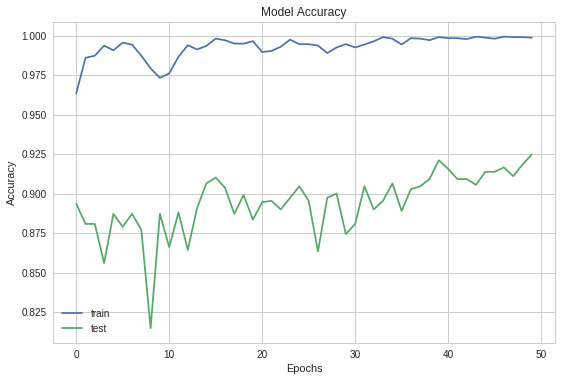

In [98]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Note that the graphs as well as the results clearly show that there is significant overfitting. Also note that despite the overfitting the overall validartion accuracy has though increased from previous best of about 0.815 to a whopping 0.93.

## 4 ) Visualizing Predictons on the Validation Set

In [0]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [0]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

#### CORRECTLY CLASSIFIED FLOWER IMAGES

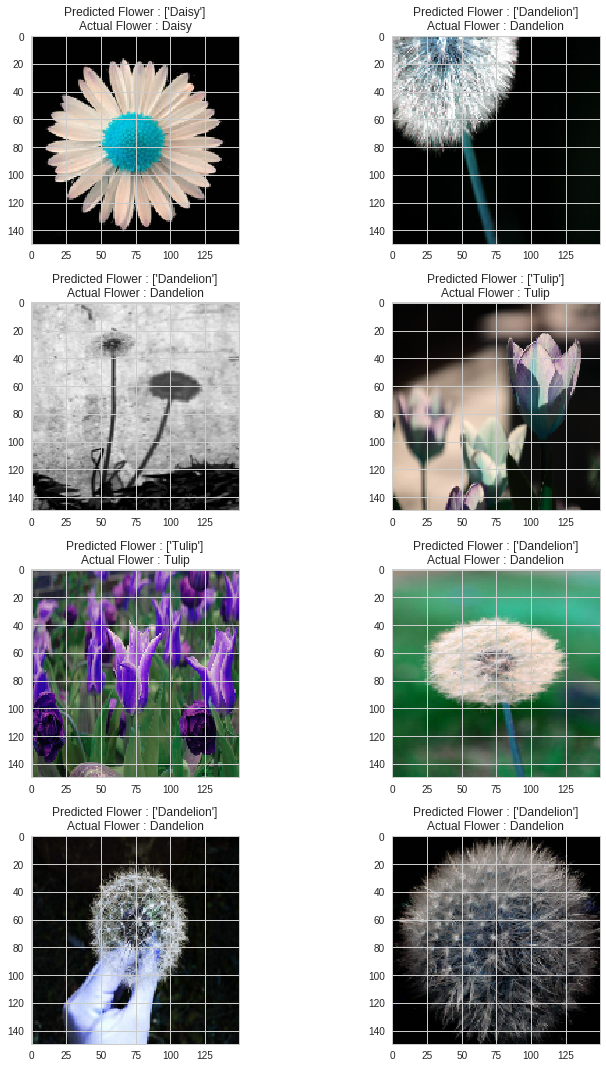

In [27]:
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

#### MISCLASSIFIED IMAGES OF FLOWERS

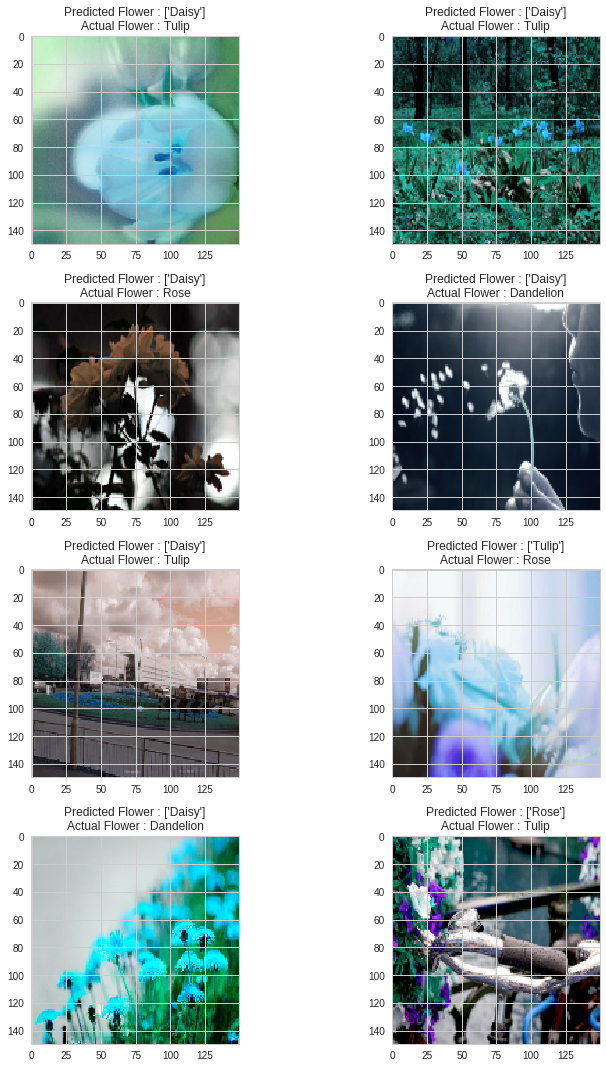

In [28]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1

## THE END.

## Please start/upvote if u like it.